In [ ]:
# !pip install opendatasets --quiet
# import opendatasets as od
# od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Raju1910
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:03<00:00, 207MB/s]


In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.preprocessing import LabelEncoder

from PIL import Image

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import os

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
path = '/content/animal-faces/afhq'

image_path =[]
labels = []

for i in os.listdir(path):
  for label in os.listdir(f'{path}/{i}'):
    for image in os.listdir(f"{path}/{i}/{label}"):
      image_path.append(f'{path}/{i}/{label}/{image}')
      labels.append(label)

In [ ]:
data_df = pd.DataFrame(
    zip(image_path, labels),
    columns=["Image_path", "Labels"]
)

In [ ]:
data_df.head()

,Image_path,Labels
0,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat
1,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat
2,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat
3,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat
4,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat


In [ ]:
train = data_df.sample(frac=0.8, random_state=42)
test = data_df.drop(train.index)
val = test.sample(frac=0.5, random_state=42)
test = test.drop(val.index)

In [ ]:
train.shape, test.shape, val.shape

((12904, 2), (1613, 2), (1613, 2))

In [ ]:
label_encoder = LabelEncoder()

label_encoder.fit(data_df['Labels'])

LabelEncoder()

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32)
])

In [ ]:
class dataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(dataframe["Labels"])).to(device)

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    image_path = self.dataframe.iloc[idx, 0]
    label = self.labels[idx]
    image = Image.open(image_path).convert("RGB")

    if self.transform:
      image = self.transform(image).to(device)

    return image, label

In [ ]:
train_data = dataset(train, transform=transform)
test_data = dataset(test, transform=transform)
val_data = dataset(val, transform=transform)

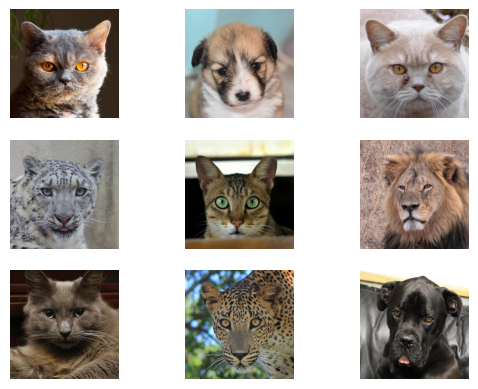

In [ ]:
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for i in range(n_rows):
  for j in range(n_cols):
    image = Image.open(data_df.sample(n = 1)["Image_path"].iloc[0]).convert("RGB")
    axarr[i, j].imshow(image)
    axarr[i, j].axis('off')

In [ ]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [ ]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.pooling = nn.MaxPool2d(2, 2)
    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()
    self.linear = nn.Linear((128 * 16 * 16), 128)
    self.output = nn.Linear(128, len(data_df['Labels'].unique()))

  def forward(self, x):
    x = self.conv1(x)
    x = self.pooling(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.pooling(x)
    x = self.relu(x)
    x = self.conv3(x)
    x = self.pooling(x)
    x = self.relu(x)
    x = self.flatten(x)
    x = self.linear(x)
    x = self.output(x)

    return x

In [ ]:
model = Net().to(device)

In [ ]:
from torchsummary import summary
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


In [ ]:
for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_data.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_data.__len__())*100, 4))
  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_data.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_data.__len__() * 100, 4)}''')
  print("="*25)

Epoch 1/10, Train Loss: 1.054 Train Accuracy 95.2263
              Validation Loss: 0.1062 Validation Accuracy: 96.3422
Epoch 2/10, Train Loss: 0.7135 Train Accuracy 97.0087
              Validation Loss: 0.097 Validation Accuracy: 96.2802
Epoch 3/10, Train Loss: 0.5131 Train Accuracy 97.7991
              Validation Loss: 0.1199 Validation Accuracy: 95.9702
Epoch 4/10, Train Loss: 0.4247 Train Accuracy 98.1324
              Validation Loss: 0.0853 Validation Accuracy: 96.7142
Epoch 5/10, Train Loss: 0.2982 Train Accuracy 98.7291
              Validation Loss: 0.1327 Validation Accuracy: 95.5983
Epoch 6/10, Train Loss: 0.2094 Train Accuracy 99.1476
              Validation Loss: 0.0954 Validation Accuracy: 96.9622
Epoch 7/10, Train Loss: 0.1698 Train Accuracy 99.3103
              Validation Loss: 0.1004 Validation Accuracy: 97.0242
Epoch 8/10, Train Loss: 0.1394 Train Accuracy 99.473
              Validation Loss: 0.0798 Validation Accuracy: 97.5821
Epoch 9/10, Train Loss: 0.0903 Trai

In [46]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_data.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")


Accuracy Score is: 96.9622 and Loss is 0.0121


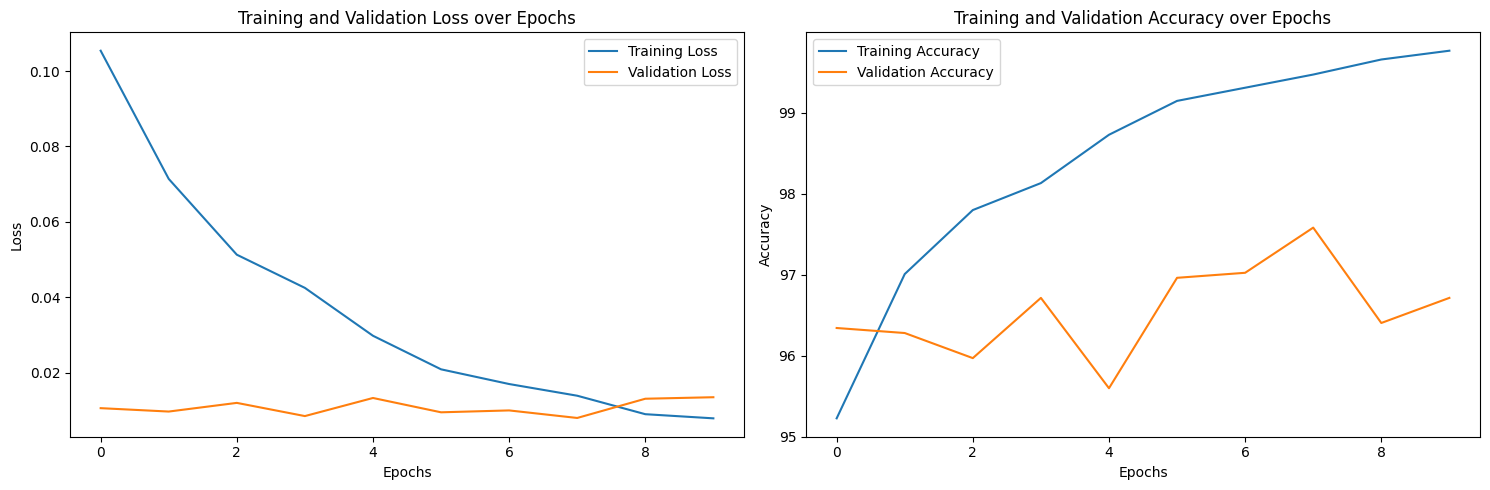

In [47]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

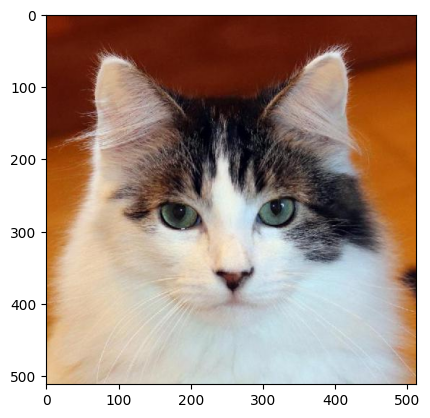


Prediction: 



array(['cat'], dtype=object)

In [49]:
def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

## Visualize the image
image = Image.open("/content/animal-faces/afhq/val/cat/flickr_cat_000008.jpg")
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image("/content/animal-faces/afhq/val/cat/flickr_cat_000008.jpg")